# Process
In this notebook, I will do a first analysis of properties distribution on the data so that I can use it later on.

# A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import users_and_items, user_gender_distribution,user_birthyear_distribution,user_country_distribution, calculate_group_characteristics
from plots import plot_gender_difference_distribution, plot_profile_size_vs_gender_difference, plot_group_characteristics
from plots import plot_country_distribution, plot_profile_size_vs_USA_ratio, plot_birthyear_distribution, plot_profile_size_vs_1950_ratio
from split_users import split
from collections import Counter

# B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_users = 0.2# the limit for a user to be considered High Preference
split_gender_by = "male_female_difference" 
split_country_by = "ratio_USA"

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfu"+str(int(100*top_fraction_users))
addition_gender = addition_2 + "_mfd"
addition_country = addition_2 + "_USAr"
addition_birthyear = addition_2 + "_1950r"

In [4]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

# C. Read files

In [6]:
processed_file_location = "data/processed/" # here we store the processed data files

In [7]:
properties_file_location = "data/files_with_properties/" # here are stored the data files that include author properties

ratings_file = properties_file_location + "fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv" # the ratings file
ratings_with_properties = pd.read_csv(ratings_file, index_col=0, header=0, low_memory=False).fillna("")

In [8]:
ratings_with_properties.head()

,User-ID,ISBN,Book-Rating,title,author,year,publisher,alt_title,alt_author,correct_author,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
1,276847,3551551677,10,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Stein der Weisen,Joanne K. Rowling,Joanne K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
2,276847,3551551685,10,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH,Harry Potter und die Kammer des Schreckens (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
3,276847,3551551693,10,Harry Potter und der Gefangene von Azkaban,J. K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Gefangene von Askaban (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
4,276847,3551551936,10,Harry Potter Und Der Feuerkelch,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Feuerkelch (Harry Potter 4),J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
5,276964,0345354621,10,The Terminal Man,Michael Crichton,1988.0,Ballantine Books,The Terminal Man,Michael Crichton,Michael Crichton,...,Q172140,,United States of America,,deism,male,,1942.0,2008.0,Michael Crichton


# D. Preprocess data
1. Convert book IDs into numbers (needed for Cornac).

In [9]:
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for ISBN in ratings_with_properties.ISBN.unique():
    mapping_dict[ISBN] = i
    i+=1

In [10]:
ratings_with_properties.ISBN = ratings_with_properties.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file

In [11]:
ratings_with_properties.head(2)

,User-ID,ISBN,Book-Rating,title,author,year,publisher,alt_title,alt_author,correct_author,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
1,276847,0,10,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Stein der Weisen,Joanne K. Rowling,Joanne K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling
2,276847,1,10,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH,Harry Potter und die Kammer des Schreckens (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,,United Kingdom,English,Anglicanism,female,English people,1965.0,,J. K. Rowling


# E. Gender analysis

First, I am replacing empty gender entries with "unknown" and all the non male or female with "other".

In [12]:
df = ratings_with_properties.copy()
df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
df["gender"] = df["gender"].apply(lambda x: "other" if (x!="male") & (x!="female") & (x!="unknown") else x)

Here is a plot of the gender distribution within the ratings.

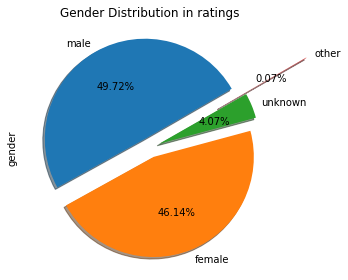

In [13]:
fig, ax = plt.subplots()
df.gender.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in ratings")
fig.tight_layout()

## E1. Define and calculate gender odds

First, I will keep only the relevant columns.

In [14]:
df_gender = df[["User-ID", "ISBN", "Book-Rating", "gender"]]

In [15]:
df_gender.head()

,User-ID,ISBN,Book-Rating,gender
1,276847,0,10,female
2,276847,1,10,female
3,276847,2,10,female
4,276847,3,10,female
5,276964,4,10,male


Then, I call a function to calculate the gender distribution per user.

The way I do it is by calculating: <br>
mw = number of books in profile written by male authors<br>
fw = number of books in profile written by female authors<br>
tb = number of books in profile <br>

<u>So for every user u, I define <i>male_female_difference</i> as:</u>

male_female_difference(u) = (mw(u) - fw(u))/tb(u)

<b>Basically the percentage of books written by male authors minus the percentage of books written by female authors </b>

In [16]:
user_gender_dist, num_users = user_gender_distribution(df_gender, user_col, split_gender_by,  prnt = True)

Mean male_female_differences per user: 0.06091
Standard deviation of male_female_differences per user: 0.52492
Min male_female_differences per user: -1.0
Max male_female_differences per user: 1.0


In [17]:
user_gender_dist.head()

,num_female,num_male,num_other,num_unknown,num_total,ratio_female,male_female_difference
276847,4,0,0,0,4,1.0,-1.0
211961,9,0,0,0,9,1.0,-1.0
214348,5,0,0,0,5,1.0,-1.0
217444,5,0,0,0,5,1.0,-1.0
54512,5,0,0,0,5,1.0,-1.0


## E2. Plot gender distribution among users 

First, I will plot the sorted differences.

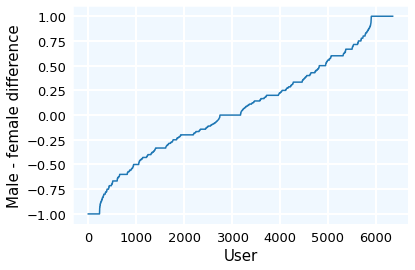

In [18]:
plot_gender_difference_distribution(user_gender_dist.male_female_difference.values)

Then I will plot if there is a relation between user profile size and difference between male and female written books in profile.

R-value: -0.04784654555542546


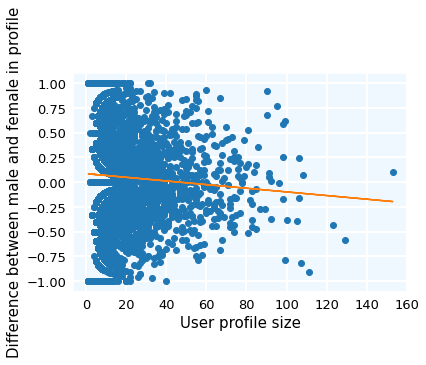

In [19]:
plot_profile_size_vs_gender_difference(user_gender_dist.male_female_difference.values,user_gender_dist.num_total.values)

## E3. Divide Users based on gender distribution

First, I will divide the users into low male preference, medium male preference and high male preference.

In [20]:
low_mp, med_mp, high_mp = split(user_gender_dist, top_fraction_users)

Then, I will calculate the characteristics of each group.

In [21]:
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users = calculate_group_characteristics(low_mp, med_mp, high_mp, count_column = "num_total", way = "gender")

Female Oriented: 12.14
Diverse: 15.36
Male Oriented: 9.74


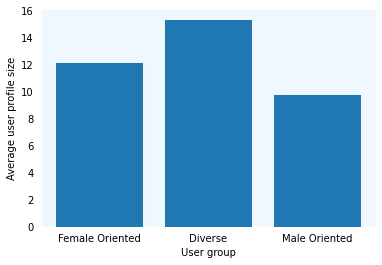

In [22]:
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size,analysis_type = "gender")

Female Oriented: 1270
Diverse: 3813
Male Oriented: 1271


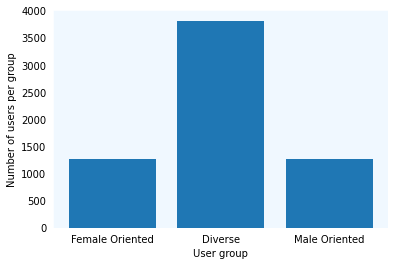

In [23]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users,analysis_type = "gender", way = "number of users")

Female Oriented: -0.68
Diverse: 0.06
Male Oriented: 0.81


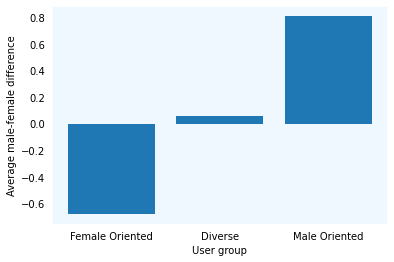

In [24]:
low_mp_ave = low_mp.male_female_difference.mean()
med_mp_ave = med_mp.male_female_difference.mean()
high_mp_ave = high_mp.male_female_difference.mean()
plot_group_characteristics(low_mp_ave, med_mp_ave, high_mp_ave,analysis_type = "gender", way = "specific metric")

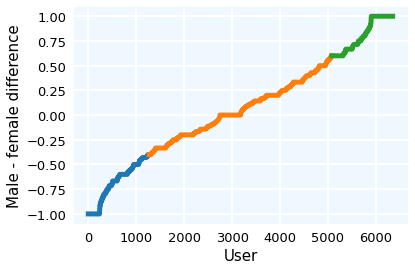

In [25]:
plot_gender_difference_distribution(user_gender_dist.male_female_difference.values, dividing = [True,top_fraction_users])

# F. Country analysis

First, I am replacing any empty country with "unknown".

In [26]:
df["country"] = df["country"].apply(lambda x: "unknown" if x=="" else x)

Then, I am calculating the 5 most common countries in the dataset.

In [27]:
most_common_5 = [x[0] for x in Counter(df.country).most_common()[:5]]
print(most_common_5)

['United States of America', 'United Kingdom', 'unknown', 'Canada', 'Republic of Ireland']


Finally, I am naming any non most common country as "other".

In [28]:
df["country"] = df["country"].apply(lambda x: "other" if (x in most_common_5) == False else x)

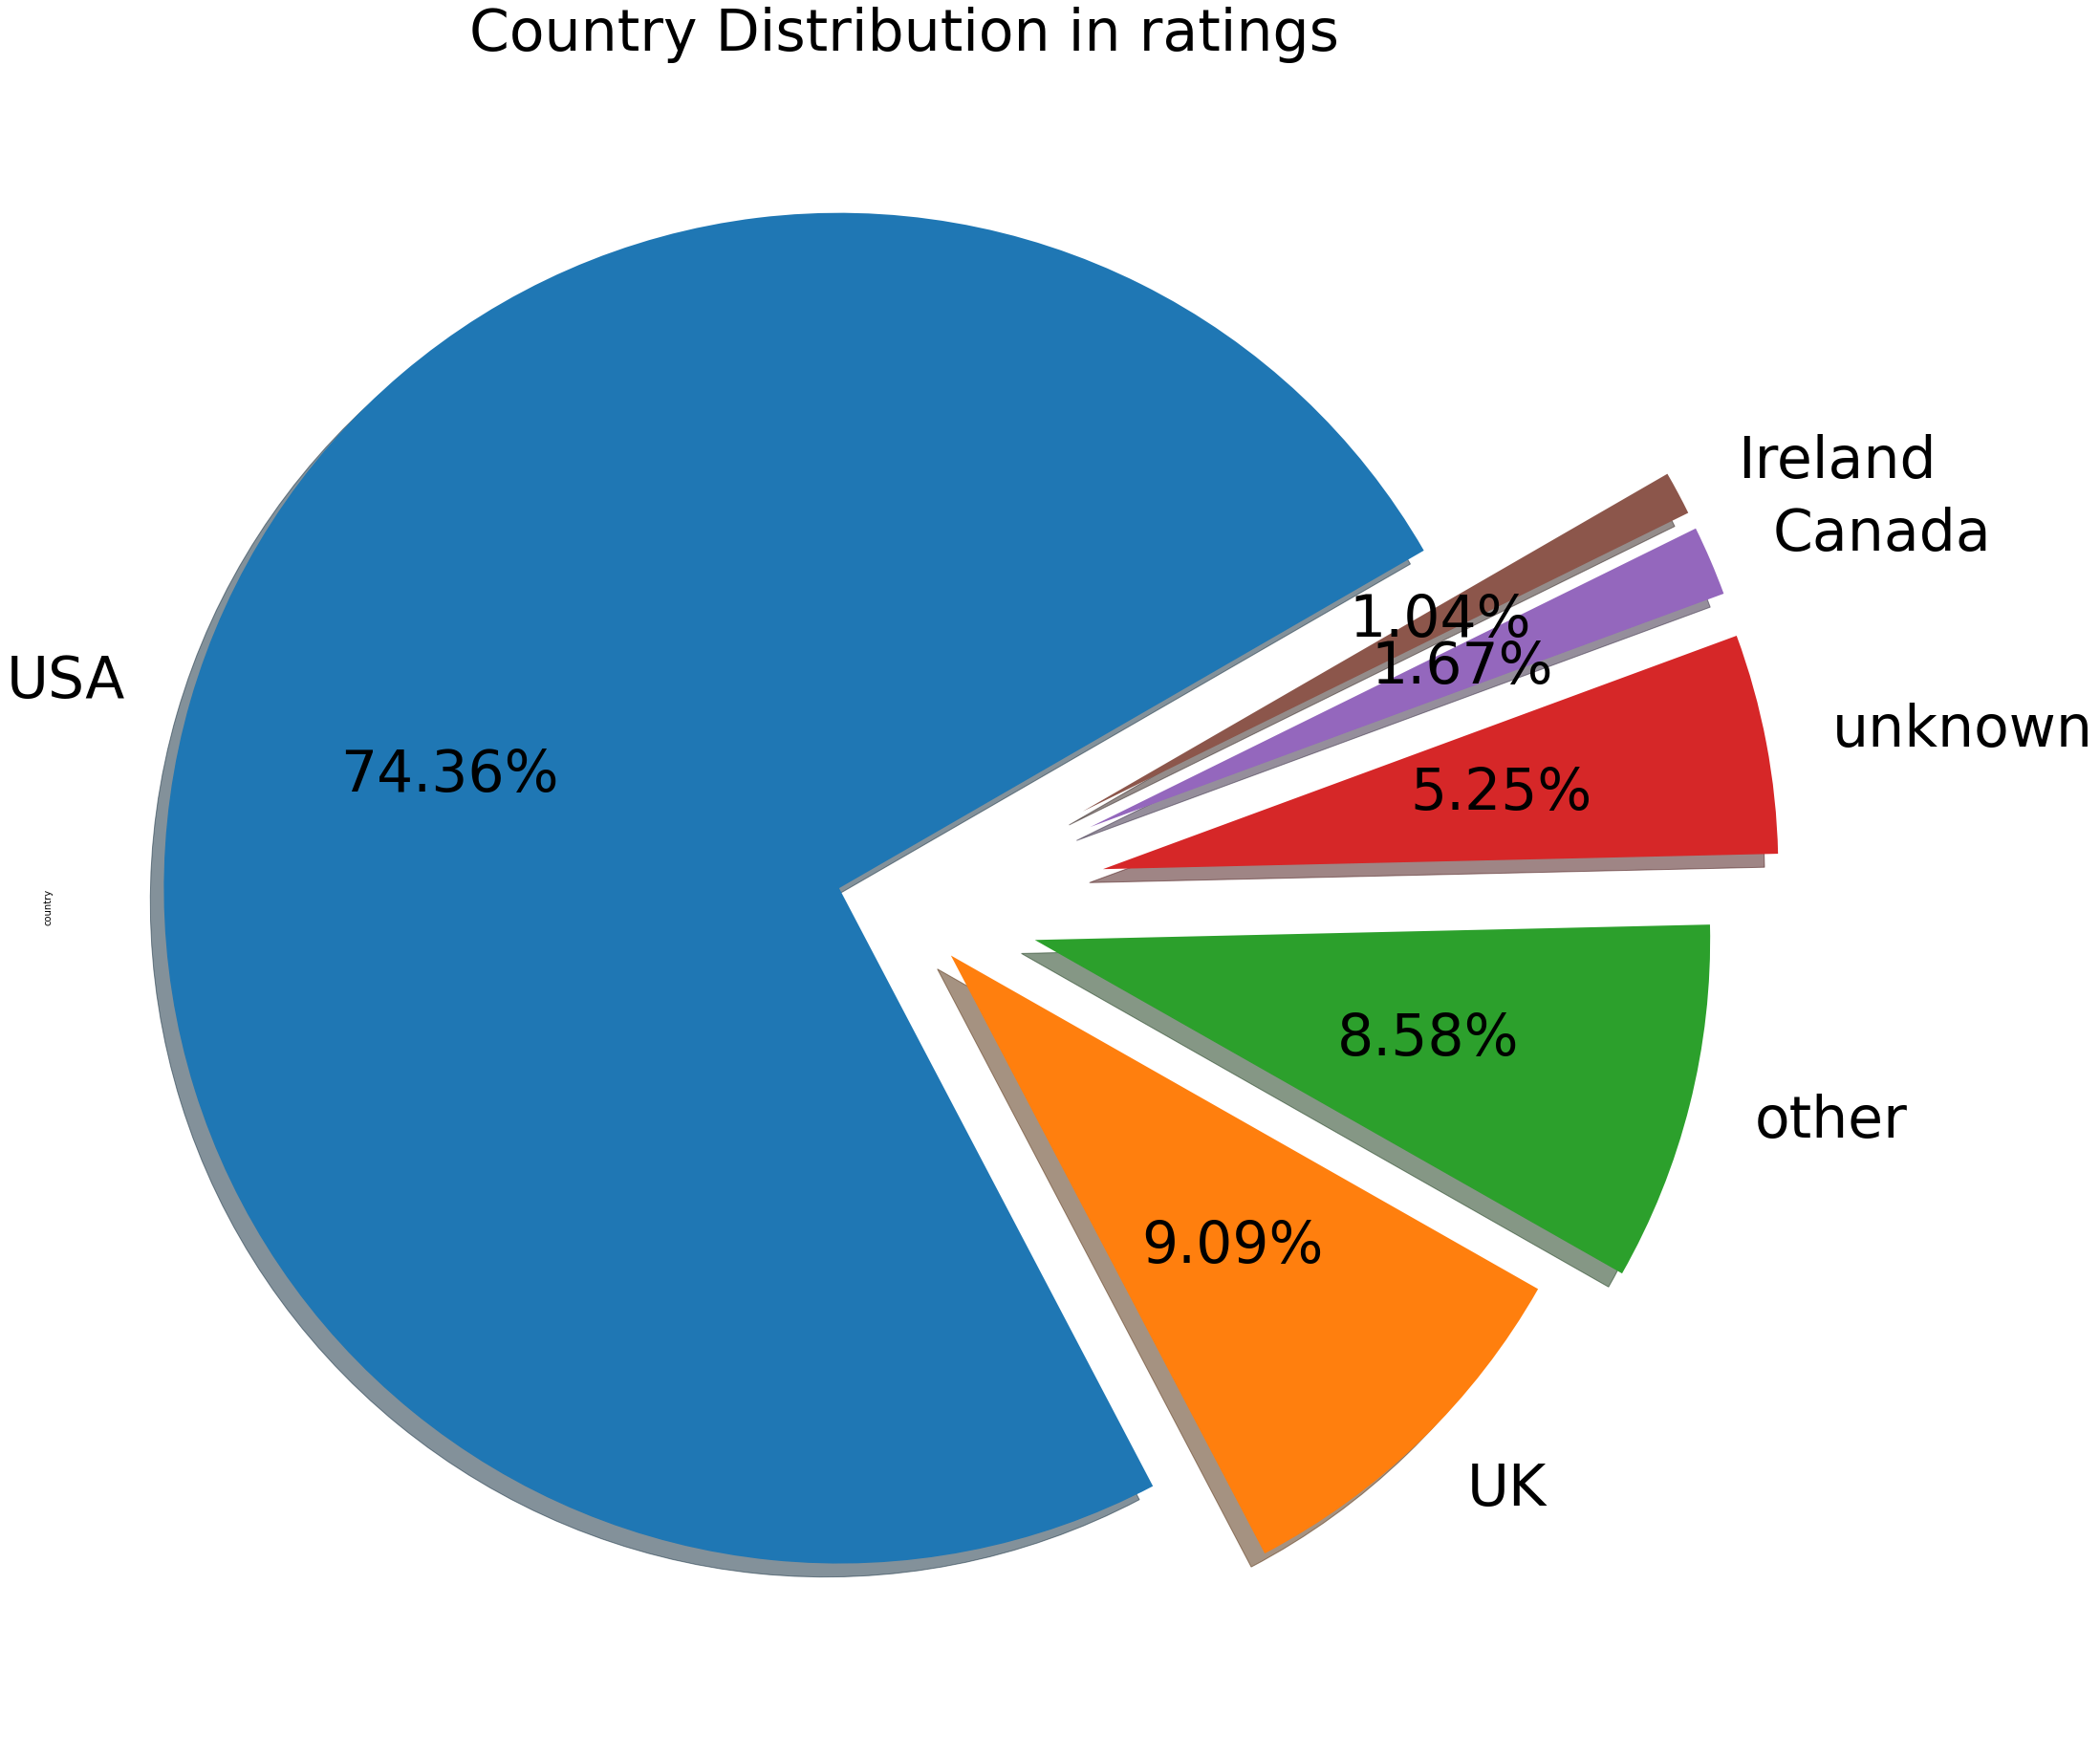

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 30)
df.country = df.country.replace("United States of America", "USA")
df.country = df.country.replace("United Kingdom", "UK")
df.country = df.country.replace("Republic of Ireland", "Ireland")
df.country.value_counts().plot(kind="pie",autopct='%.2f%%',shadow=True, explode = [0.1,0.1,0.2,0.3,0.3,0.3]
                                      , startangle=30,
                              fontsize=60)
ax.title.set_text("Country Distribution in ratings") 
ax.title.set_fontsize(60)
fig.tight_layout()

## F1. Define and calculate country odds

First, I will keep only the relevant columns

In [30]:
df_country = df[["User-ID", "ISBN", "Book-Rating", "country"]]

In [31]:
df_country.head()

,User-ID,ISBN,Book-Rating,country
1,276847,0,10,UK
2,276847,1,10,UK
3,276847,2,10,UK
4,276847,3,10,UK
5,276964,4,10,USA


Then, I call a function to calculate the country distribution per user.

The way I do it is by calculating: <br>
nUSA = number of books in profile written by USA citizens<br>
tb = number of books in profile <br>

<u>So for every user u, I define <i>ratio_USA</i> as:</u>

ratio_USA(u) = nUSA(u)/tb(u)

<b>Basically the percentage of books written by USA citizens</b>

In [32]:
user_country_dist, num_users = user_country_distribution(df_country, user_col, split_country_by,  prnt = True)

Mean ratio_USAs per user: 0.73886
Standard deviation of ratio_USAs per user: 0.21338
Min ratio_USAs per user: 0.0
Max ratio_USAs per user: 1.0


## F2. Plot country distribution among users

First, I will plot the sorted ratios.

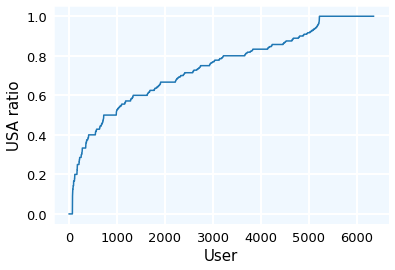

In [33]:
plot_country_distribution(user_country_dist.ratio_USA.values)

Then I will plot if there is a relation between user profile size and ratio of books written by USA citizens in profile.

R-value: 0.022143364334910338


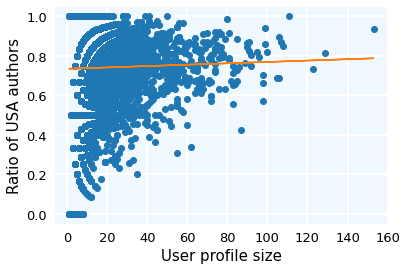

In [34]:
plot_profile_size_vs_USA_ratio(user_country_dist.ratio_USA.values,user_country_dist.num_total.values)

## F3. Divide Users based on country distribution

First, I will divide the users into low USA preference, medium USA preference and high USA preference.

In [35]:
low_Up, med_Up, high_Up = split(user_country_dist, top_fraction_users)

Then, I will calculate the characteristics of each group.

In [36]:
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users = calculate_group_characteristics(low_Up, med_Up, high_Up, count_column = "num_total", way = "country")

low USA Oriented: 11.31
mid USA Oriented: 15.76
USA Oriented: 9.36


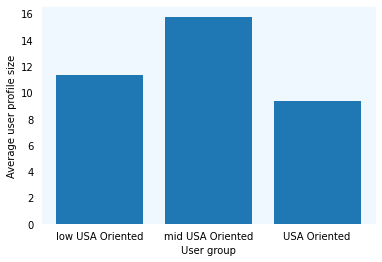

In [37]:
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size,analysis_type = "country")

low USA Oriented: 1270
mid USA Oriented: 3813
USA Oriented: 1271


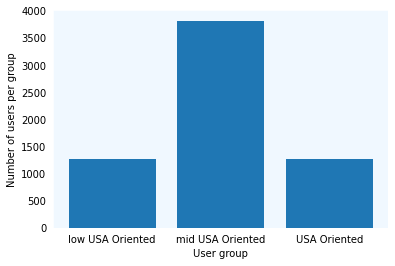

In [38]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users,analysis_type = "country", way = "number of users")

low USA Oriented: 0.41
mid USA Oriented: 0.76
USA Oriented: 0.99


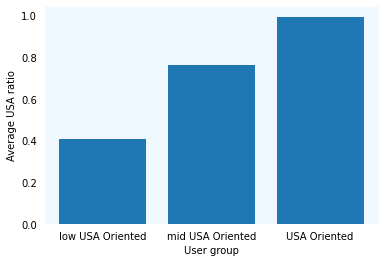

In [39]:
low_Up_ave = low_Up.ratio_USA.mean()
med_Up_ave = med_Up.ratio_USA.mean()
high_Up_ave = high_Up.ratio_USA.mean()
plot_group_characteristics(low_Up_ave, med_Up_ave, high_Up_ave,analysis_type = "country", way = "specific metric")

# G. Birthyear analysis

In [40]:
df["birthyear_coded"] = df["birthyear"].apply(lambda x: "1000000" if x=="" else x)
df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "2000000" if int(x)<0 else x)
df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "3000000" if (int(x)>=0)&(int(x)<1900) else x)
df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "4000000" if (int(x)>=1900)&(int(x)<1950) else x)
df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "5000000" if (int(x)>=1950)&(int(x)<2050) else x)

In [41]:
df.birthyear_coded = df.birthyear_coded.replace("1000000","unknown")
df.birthyear_coded = df.birthyear_coded.replace("2000000","B.C.")
df.birthyear_coded = df.birthyear_coded.replace("3000000","0-1900")
df.birthyear_coded = df.birthyear_coded.replace("4000000","1900-1950")
df.birthyear_coded = df.birthyear_coded.replace("5000000","1950-2000")

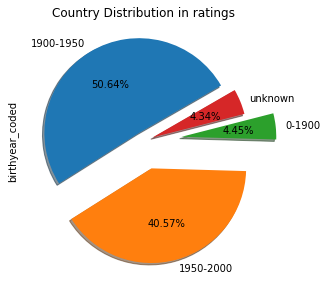

In [42]:
fig, ax = plt.subplots()
df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.3, 0.4,0.1), shadow=True
                                      , startangle=30)
ax.title.set_text("Country Distribution in ratings")    
fig.tight_layout()

In [43]:
df.birthyear = df.birthyear_coded

## G1. Define and calculate birthyear odds

First, I will keep only the relevant columns

In [44]:
df_birthyear = df[["User-ID", "ISBN", "Book-Rating", "birthyear"]]

In [45]:
df_birthyear.head()

,User-ID,ISBN,Book-Rating,birthyear
1,276847,0,10,1950-2000
2,276847,1,10,1950-2000
3,276847,2,10,1950-2000
4,276847,3,10,1950-2000
5,276964,4,10,1900-1950


Then, I call a function to calculate the country distribution per user.

The way I do it is by calculating: <br>
nUSA = number of books in profile written by USA citizens<br>
tb = number of books in profile <br>

<u>So for every user u, I define <i>ratio_USA</i> as:</u>

ratio_USA(u) = nUSA(u)/tb(u)

<b>Basically the percentage of books written by USA citizens</b>

In [46]:
user_birthyear_dist, num_users = user_birthyear_distribution(df_birthyear, user_col, "ratio_1950",  prnt = True)

Mean ratio_1950s per user: 0.50909
Standard deviation of ratio_1950s per user: 0.2315
Min ratio_1950s per user: 0.0
Max ratio_1950s per user: 1.0


## G2. Plot birthyear distribution among users

First, I will plot the sorted ratios.

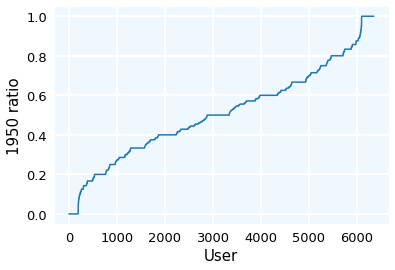

In [47]:
plot_birthyear_distribution(user_birthyear_dist.ratio_1950.values)

Then I will plot if there is a relation between user profile size and ratio of books written by 1900-1950 citizens in profile.

R-value: -0.011754457030425856


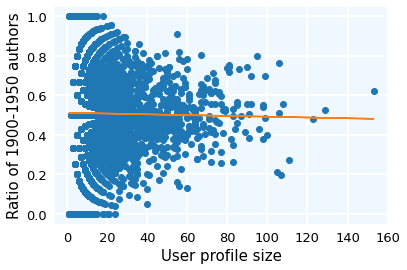

In [48]:
plot_profile_size_vs_1950_ratio(user_birthyear_dist.ratio_1950.values,user_birthyear_dist.num_total.values)

## F3. Divide Users based on country distribution

First, I will divide the users into low USA preference, medium USA preference and high USA preference.

In [49]:
low_1950p, med_1950p, high_1950p = split(user_birthyear_dist, top_fraction_users)

Then, I will calculate the characteristics of each group.

In [50]:
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users = calculate_group_characteristics(low_1950p, med_1950p, high_1950p, count_column = "num_total", way = "birthyear")

low 1950 Oriented: 11.23
mid 1950 Oriented: 15.38
1950 Oriented: 10.59


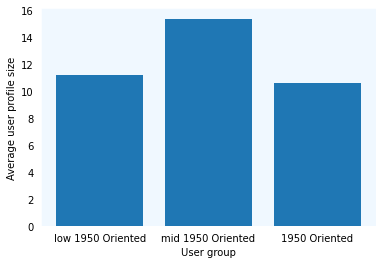

In [51]:
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size,analysis_type = "birthyear")

low 1950 Oriented: 1270
mid 1950 Oriented: 3813
1950 Oriented: 1271


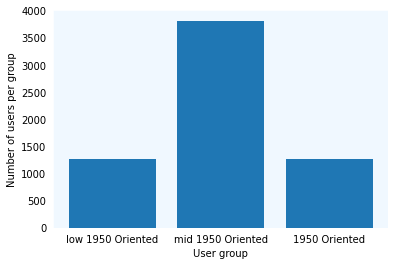

In [52]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users,analysis_type = "birthyear", way = "number of users")

low 1950 Oriented: 0.18
mid 1950 Oriented: 0.51
1950 Oriented: 0.84


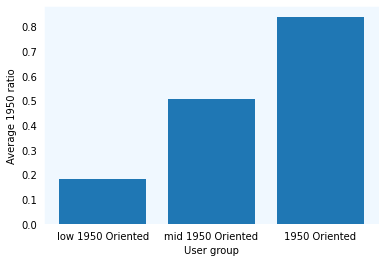

In [53]:
low_1950p_ave = low_1950p.ratio_1950.mean()
med_1950p_ave = med_1950p.ratio_1950.mean()
high_1950p_ave = high_1950p.ratio_1950.mean()
plot_group_characteristics(low_1950p_ave, med_1950p_ave, high_1950p_ave,analysis_type = "birthyear", way = "specific metric")

## G. Save Processed Data
Now we will save all the files that are needed for training the Recommender Systems and analyzing the results.
1. The Female Oriented, Diverse and Male Oriented users.
2. The low, mid and high USA oriented users.
3. "Mapped" files.

First, I will merge the files.

In [54]:
final_df = pd.merge(pd.merge(df_gender, df_country, on = ["User-ID", "ISBN", "Book-Rating"]),df_birthyear,on = ["User-ID", "ISBN", "Book-Rating"])

In [55]:
final_df

,User-ID,ISBN,Book-Rating,gender,country,birthyear
0,276847,0,10,female,UK,1950-2000
1,276847,1,10,female,UK,1950-2000
2,276847,2,10,female,UK,1950-2000
3,276847,3,10,female,UK,1950-2000
4,276964,4,10,male,USA,1900-1950
...,...,...,...,...,...,...
86351,276688,5443,7,female,USA,1900-1950
86352,276688,1465,6,female,USA,1900-1950
86353,276688,3655,8,female,USA,1950-2000
86354,276688,4244,10,male,USA,1950-2000


In [56]:
low_mp.to_csv(processed_file_location + recommendation_type +"/low_users"+addition_gender+"_new.csv")
med_mp.to_csv(processed_file_location +recommendation_type + "/med_users"+addition_gender+"_new.csv")
high_mp.to_csv(processed_file_location +recommendation_type + "/high_users"+addition_gender+"_new.csv")

In [57]:
low_Up.to_csv(processed_file_location + recommendation_type +"/low_users"+addition_country+"_new.csv")
med_Up.to_csv(processed_file_location +recommendation_type + "/med_users"+addition_country+"_new.csv")
high_Up.to_csv(processed_file_location +recommendation_type + "/high_users"+addition_country+"_new.csv")

In [58]:
low_1950p.to_csv(processed_file_location + recommendation_type +"/low_users"+addition_birthyear+"_new.csv")
med_1950p.to_csv(processed_file_location +recommendation_type + "/med_users"+addition_birthyear+"_new.csv")
high_1950p.to_csv(processed_file_location +recommendation_type + "/high_users"+addition_birthyear+"_new.csv")

In [59]:
final_df.to_csv(processed_file_location +recommendation_type + "/mapped_ratings_with_properties_new.csv")